In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

In [2]:
def kernel(X1, X2, scale=1.0, sigma_f=1.0): #Generates a kernel
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#    ''' Uncomment for Linear Kernel '''
#    return X1 @ X2.T

In [3]:
def dataSet2(): #Generates dataset
    X, y = make_moons(n_samples=100, noise=0.1) #X is a 100x2 set of points, y is (100,) array of classification values. 0 for below X-axis, 1 for above
    y = np.where(y==0, -1, y)      #Makes the 0 values to -1
    y = y.reshape(-1,1)            #Reshapes it for ez processing
    S = (y>0).squeeze()            #S contains boolean values
    x_pos = X[S]                   #Contains all positive X values
    x_neg = X[np.invert(S)]        #Constains all negative X values
    return X,y,x_pos,x_neg         

In [4]:
def dualOptimizer(H,m,y):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H) #Converts H into a cvxopt matrix with e-notation
    q = cvxopt_matrix(-np.ones((m, 1))) #mx1 matrix having -1
    G = cvxopt_matrix(-np.eye(m))  #mxm identity matrix with value -1 instead of 1
    h = cvxopt_matrix(np.zeros(m)) #mx1 array of zeros
    A = cvxopt_matrix(y.reshape(1, -1))  #just the y array reshaped as (1,100)
    b = cvxopt_matrix(np.zeros(1)) #one zero value but in cvxopt form
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    '''
    Solves a quadratic program

    minimize    (1/2)*x'*P*x + q'*x
    subject to  G*x <= h
                A*x = b.
                
    if h and b are 0's it is effectively having no slack.
    thus changing them to some constant value (<1) would be implementation of slack and thus soft margins
'''
    sol = cvxopt_solvers.qp(P, q, G, h, A, b) #is the default output of the solvers, refer documentation for more info
    alphas = np.array(sol['x']) # is the alpha values (lambda values for the lagrange multipliers)
    return alphas

In [6]:
def pred(y,a,X,p,b): #predicts p value
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    #predicts b value
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)

In [9]:
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape

alphas = dualOptimizer(H,m,y)

#Selecting the set of indices S corresponding to non zero parameters
S = (alphas > 1e-4).flatten()

w = ((y[S] * alphas[S]).T @ X[S]).reshape(-1,1)

#Computing b
b = predb(y[S],alphas[S],X[S],X[S])

#Display results
print('Alphas: ',alphas,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b)


(8, 8) (1, 8)
Alphas:  [[2.76575239e-12]
 [3.01912083e-12]
 [4.34738014e-12]
 [2.14112721e-12]
 [3.24331752e-12]
 [1.18353802e-11]
 [7.83319635e+01]
 [4.03741897e-12]
 [3.53663195e-12]
 [2.32474517e-11]
 [9.13270543e-12]
 [4.36370868e+01]
 [4.56296574e-12]
 [4.08335273e-12]
 [4.61662586e-12]
 [2.77276606e-12]
 [1.12186409e+01]
 [3.97224619e-12]
 [3.83103730e-12]
 [1.37760409e-11]
 [3.37452227e-12]
 [3.88909662e-12]
 [4.72976083e-12]
 [6.98435610e-12]
 [3.62364535e-12]
 [6.30159919e-12]
 [3.76346624e-12]
 [3.98332923e-12]
 [3.57075426e-12]
 [8.23400885e-12]
 [6.33827629e-12]
 [2.24165400e-11]
 [7.38936278e-12]
 [3.26200603e-12]
 [2.20736574e-12]
 [1.50881434e-11]
 [3.04863474e-12]
 [6.02917039e-12]
 [2.66361701e-12]
 [9.26920658e-12]
 [3.48538147e-12]
 [6.46650561e-12]
 [1.74401475e+01]
 [1.28261295e-11]
 [3.61341177e-12]
 [1.39054035e-11]
 [3.26535751e-12]
 [4.21799652e-12]
 [1.34350876e-11]
 [2.34650001e-12]
 [5.08533270e-12]
 [2.06234063e-11]
 [5.31438127e-12]
 [7.71059804e-12]
 [2.5

<a list of 3 text.Text objects>

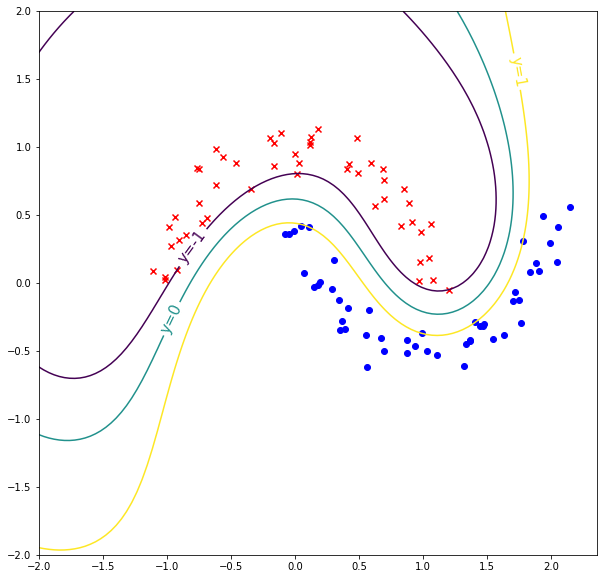

In [10]:
fig = plt.figure(figsize = (10,10))

'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas[S],X[S],p,b)
#print(pr)


'''margin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp = plt.contour(x0, x1, pred(y[S],alphas[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=15)